In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
# Load dataset
data = np.load("./drive/MyDrive/FYP/dataset.npz")

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
class_names = data['class_names']

print(f"Loaded dataset:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")



Loaded dataset:
X_train shape: (16006, 64, 64, 3)
X_test shape: (4002, 64, 64, 3)


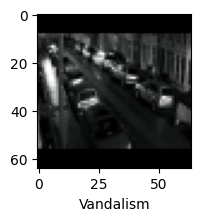

In [3]:
def plot_sample(X,y,index):
    plt.figure(figsize=(3,2))
    plt.imshow(X[index])
    plt.xlabel(class_names[y[index]])

plot_sample(X_train,y_train,9)

In [4]:
learning_rate=0.001
weight_decay=0.0001
batch_size=256
epochs=10
image_size=64
patch_size=6
num_patches=(image_size//patch_size)**2
projection_dim=64
num_heads=4
transformer_units=[
    projection_dim*2,
    projection_dim,
]#size of transformer layers
transformer_layers=8
mlp_head_units=[2048,1024]#size of the dense layers of the final classifier

In [5]:
data_augmentation = models.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

# Compute the mean and variance of training data for normalization.
data_augmentation.layers[0].adapt(X_train)


In [6]:
def mlp(x,hidden_units,dropout_rate):
  for units in hidden_units:
    x=layers.Dense(units,activation=tf.nn.gelu)(x)
    x=layers.Dropout(dropout_rate)(x)
  return x


In [7]:
class Patches(layers.Layer):
  def __init__(self,patch_size):
    super(Patches,self).__init__()
    self.patch_size=patch_size

  def call(self,images):
    batch_size=tf.shape(images)[0]
    patches=tf.image.extract_patches(
        images=images,
        sizes=[1,self.patch_size,self.patch_size,1],
        strides=[1,self.patch_size,self.patch_size,1],
        rates=[1,1,1,1],
        padding="VALID",
    )
    patch_dims=patches.shape[-1]
    patches=tf.reshape(patches, [batch_size,-1,patch_dims])
    return patches

Image size: 64 X 64
Patch size: 6 X 6
Patches per image: 100
Elements per patch: 108


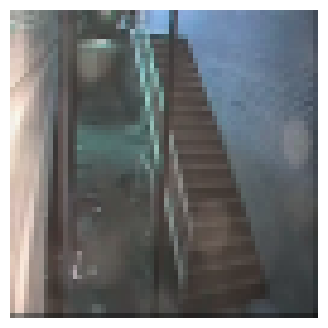

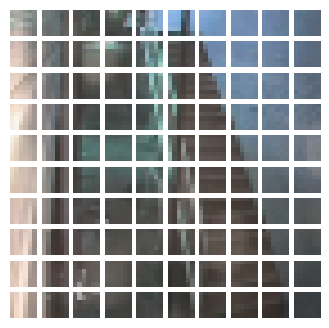

In [8]:
plt.figure(figsize=(4,4))
# image=X_train[np.random.choice(range(X_train.shape[0]))]
image=X_train[1]
plt.imshow((image * 255).astype("uint8"))
plt.axis("off")

resized_image=tf.image.resize(
    tf.convert_to_tensor([image]),size=(image_size,image_size)
)

patches=Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
n=int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i,patch in enumerate(patches[0]):
  ax=plt.subplot(n,n,i+1)
  patch_img=tf.reshape(patch,(patch_size,patch_size,3))
  plt.imshow(patch_img.numpy().astype("uint8"))
  plt.imshow((patch_img.numpy() * 255).astype("uint8"))
  plt.axis("off")

In [9]:
class PatchEncoder(layers.Layer):
  def __init__(self,num_patches,projection_dim):
    super(PatchEncoder,self).__init__()
    self.num_patches=num_patches
    self.projection=layers.Dense(units=projection_dim)
    self.position_embedding=layers.Embedding(
        input_dim=num_patches,output_dim=projection_dim
    )
  def call(self,patch):
    positions=tf.range(start=0,limit=self.num_patches,delta=1)
    encoded=self.projection(patch)+self.position_embedding(positions)
    return encoded

In [10]:
def create_vit_classifier():
  inputs=layers.Input(shape=input_shape)
  augmented=data_augmentation(inputs)
  patches=Patches(patch_size)(augmented)
  encoded_patches=PatchEncoder(num_patches,projection_dim)(patches)

  for _ in range(transformer_layers):
    x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    attention_output=layers.MultiHeadAttention(
        num_heads=num_heads,key_dim=projection_dim,dropout=0.1
    )(x1,x1)
    x2=layers.Add()([attention_output,encoded_patches])
    x3=layers.LayerNormalization(epsilon=1e-6)(x2)
    x3=mlp(x3,hidden_units=transformer_units,dropout_rate=0.1)
    encoded_patches=layers.Add()([x3,x2])
  representation=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation=layers.Flatten()(representation)
  representation=layers.Dropout(0.5)(representation)
  features=mlp(representation,hidden_units=mlp_head_units,dropout_rate=0.5)
  logits=layers.Dense(num_classes)(features)
  model=tf.keras.Model(inputs=inputs,outputs=logits)
  return model

In [11]:
checkpoint_filepath="./drive/MyDrive/FYP/vit.keras.weights.h5"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

In [12]:
# input_shape = (image_size, image_size, 3)  # Assuming 64x64 RGB images
# num_classes = len(class_names)  # Ensure `class_names` is defined and valid
# model=create_vit_classifier()
# model.summary()

In [13]:
def run_experiment(model):
    # Define the optimizer with learning rate and weight decay
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Set up the checkpoint callback
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    # Load the best weights from the checkpoint
    model.load_weights(checkpoint_filepath)

    # Evaluate the model on the test set
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top-5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


In [14]:
input_shape = (image_size, image_size, 3)  # Assuming 64x64 RGB images
num_classes = len(class_names)  # Ensure `class_names` is defined and valid
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.5387 - loss: 2.9886 - top-5-accuracy: 0.8264
Epoch 1: val_accuracy improved from -inf to 0.92130, saving model to ./drive/MyDrive/FYP/vit.keras.weights.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 55s 287ms/step - accuracy: 0.5409 - loss: 2.9638 - top-5-accuracy: 0.8280 - val_accuracy: 0.9213 - val_loss: 0.2637 - val_top-5-accuracy: 0.9956
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8669 - loss: 0.4284 - top-5-accuracy: 0.9924
Epoch 2: val_accuracy improved from 0.92130 to 0.98501, saving model to ./drive/MyDrive/FYP/vit.keras.weights.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step - accuracy: 0.8674 - loss: 0.4269 - top-5-accuracy: 0.9924 - val_accuracy: 0.9850 - val_loss: 0.0731 - val_top-5-accuracy: 0.9975
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9474 - loss: 0.1666 - top-5-accuracy: 0.9978
Epoch 3: val_accuracy improved from 0.98501 to 0.99001, saving model to ./drive/MyDrive/FYP/vit.kera